<a href="https://colab.research.google.com/github/lucasbens/ML_projects/blob/main/titanic_top_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Project

- The goal of the project is to correctly predict if someone survived the Titanic shipwreck on April 15, 1912. 

- In this notebook, I follow a step-by-step workflow to show how I am working through the problem with deep details and visualizations.

<br>
<br>

Comment:

- My first notebook had an accuraccy around 75% and I was in the bottom of the leaderboard. As a data scientist for 2 years, my self-esteem took a hit. 

- I improved my accuracy to 78.468% by looking others Notebook it helped me  to create a new variable: connected_survival, it gives a score correlated to the number of survivors per family.

- I am open to feedbacks


<br>

**Best results : 78.468 % accuracy (Top 10%)**

<br>

### Workflow stages:


##### 1) Import data

##### 2) Exploratory data analysis (EDA)

##### 3) Feature engineering 

##### 4) Modeling

##### 5) Submission


# Import data

In [1]:
%%capture
! pip install lazypredict

# Scikit-learn packages
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, r2_score

# import models
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import xgboost 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# Lazy Predict packages
from lazypredict.Supervised import LazyRegressor,LazyClassifier

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image



# Setting up max columns & rows displayed to 100
pd.options.display.max_columns = 100
pd.options.display.max_rows = 250

In [2]:
# Our datasets
directory_to_extract_to = '/kaggle/input/titanic'
# directory_to_extract_to = '/content'
df_train = pd.read_csv(directory_to_extract_to+'/train.csv')
df_test = pd.read_csv(directory_to_extract_to+'/test.csv')

# We concatenate these datasets to run certain operations on both.
dfs = [('train',df_train), ('test',df_test)]
df_full = pd.concat([df_train, df_test], axis = 0).reset_index(drop=True)

## Functions

In [3]:
def distrib(col, title='', xticks =False):
  if title =='':
    title=f'{col} distribution'

  if xticks:
    plt.figure(figsize=(20,10))
  else:
    plt.figure(figsize=(14,5))

  # subplot 1
  plt.subplot(1,2,1)

  # train
  vc_train = pd.DataFrame(df_train[col].value_counts(sort=False).sort_index().reset_index())
  vc_train['set'] = 'Train'

  # test
  vc_test = pd.DataFrame(df_test[col].value_counts(sort=False).sort_index().reset_index())
  vc_test['set'] = 'Test'

  vc = pd.concat([vc_train, vc_test], axis=0)
  sns.barplot(data = vc, x= vc['index'], y= vc[col], hue='set')
  plt.ylabel('count')
  plt.xlabel(col)
  plt.title(col+' distribution')
  if xticks:
    plt.xticks(rotation=90)

  # subplots 2
  plt.subplot(1,2,2)
  sns.countplot(x= col, data = df_train, hue = 'Survived', palette=['r','b'])
  plt.legend(loc='upper right')
  plt.title(col + ' / Survived')
  plt.suptitle(title, fontsize=16,y=1.01)

  if xticks:
    plt.xticks(rotation=90)
  plt.show()

  print('\tSurvival rate\n',df_train.groupby([col]).Survived.mean())


# EDA

### Datasets overview

We check our data types & null counts 




In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [5]:
for df in dfs:
  print(df[0],':\n')
  print(df[1].info(),'\n\n')

train :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None 


test :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null

#### Nan Values

In [6]:
# Count / percentage of Nan values per columns
for df in dfs:
  pr = pd.Series(df[1].isna().sum() / len(df[1]), name='Nan_%')
  nb = pd.Series(df[1].isna().sum(), name='Nan_cnt')
  
  print(df[0],':\n')

  display(pd.concat([nb, pr],axis =1))
  print('\n\n')

train :



,Nan_cnt,Nan_%
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,0.20
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00





test :



,Nan_cnt,Nan_%
PassengerId,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,86,0.21
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,1,0.00
Cabin,327,0.78


**Cabin** has more than 75% values in both datasets we will drop it


In [7]:
# drop cabin
for df in dfs:
  df[1].drop('Cabin', axis = 1, inplace =True)
df_full = pd.concat([df_train, df_test], axis = 0).reset_index(drop=True)


**Train & Test**:

>**Cabin** has ~75% Nan values in both datasets ---> Drop it

>**Age** has ~20% Nan values in both datasets

**Train**:

> **Embarked** from train set has 2 Nan values    

**Test**:

> **Fare** from test set has 1 Nan value

<br>

We will fill them in the following sections

### Data types

Which features are categorical? numerical?

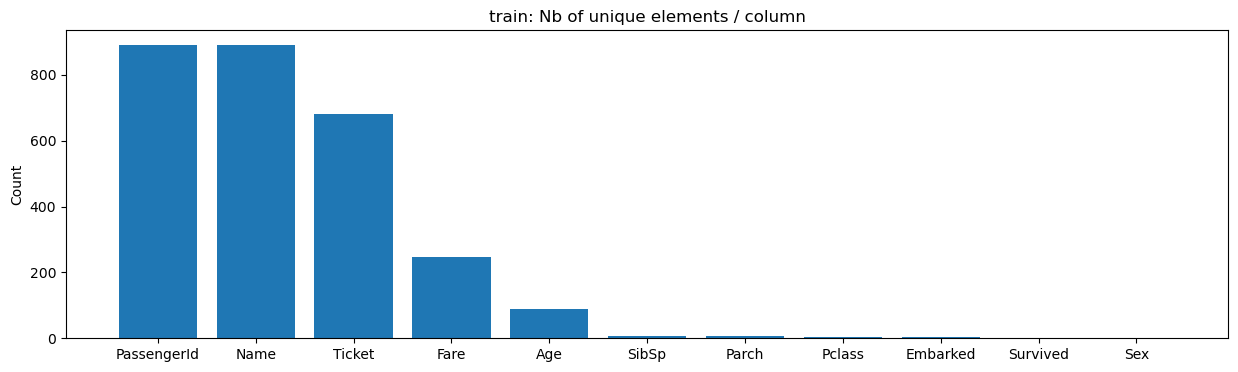



Unique element / column:


,number,percentage
PassengerId,891,1.00
Name,891,1.00
Ticket,681,0.76
Fare,248,0.28
Age,88,0.10
SibSp,7,0.01
Parch,7,0.01
Pclass,3,0.00
Embarked,3,0.00
Survived,2,0.00


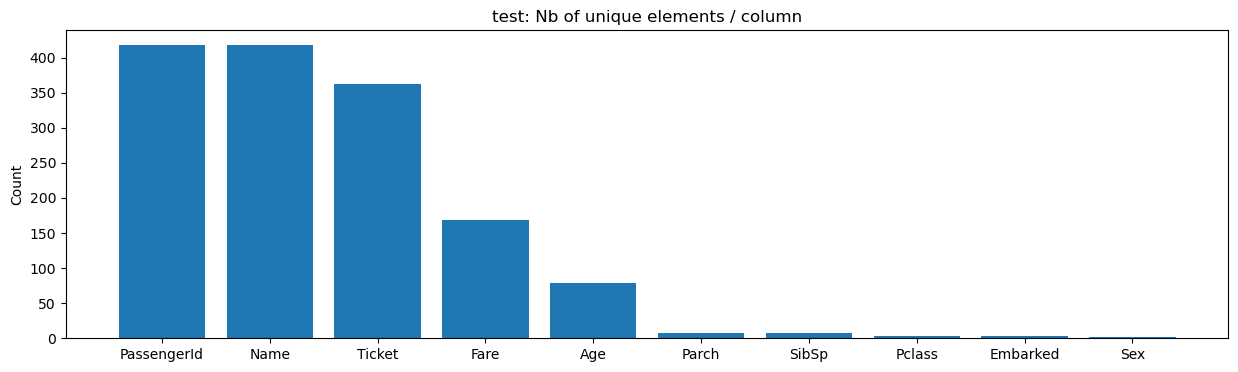



Unique element / column:


,number,percentage
PassengerId,418,1.00
Name,418,1.00
Ticket,363,0.87
Fare,169,0.40
Age,79,0.19
Parch,8,0.02
SibSp,7,0.02
Pclass,3,0.01
Embarked,3,0.01
Sex,2,0.00


In [8]:
for df in dfs:

  t = df[1].nunique().sort_values(ascending=False)

  plt.figure(figsize=(15,4))
  plt.title(f"{df[0]}: Nb of unique elements / column")
  plt.ylabel('Count')
  plt.bar(t.index, t.values)
  plt.show()

  nb = pd.Series(t, name = 'number')
  pr = pd.Series(t/len(df[1]), name = 'percentage')
  
  print('\n\nUnique element / column:')
  display(pd.concat([nb,pr], axis=1))
  print('\n\n')

**Numerical:**
- Discrete
> Parch, SibSp
- Continuous
> Fare, Age

**Categorical:**
- Nominal 
> Name, PassengerId, Ticket, Cabin, Embarked, Sex, Survived (*target*)


- Ordinal 
> Pclass

In [9]:
num_cols = ['Fare', 'Age']
num_cnt_cols = ['Parch', 'SibSp']
nominal_cols = ['Name', 'PassengerId', 'Ticket', 'Embarked', 'Sex']
ordinal_cols = ['Pclass']
target = ['Survived']

### Data distribution

#### Target distribution

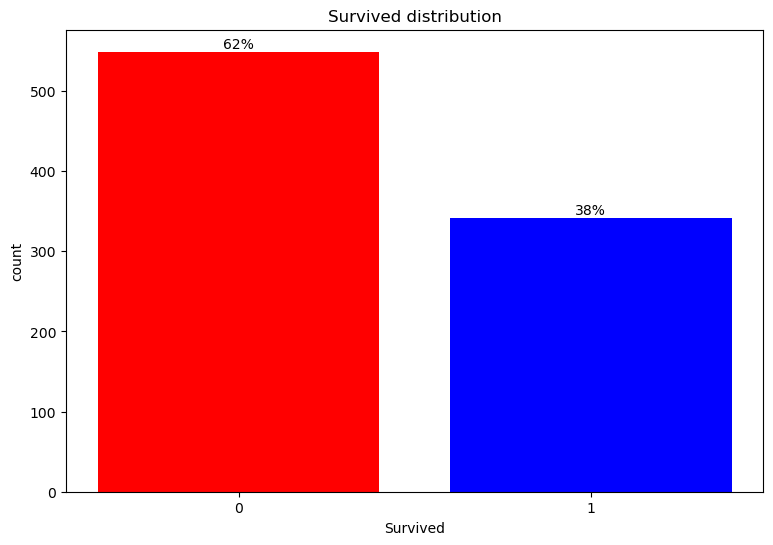

In [10]:
t = df_train['Survived'].value_counts(sort=False)

plt.figure(figsize=(9,6))
plt.bar(t.index.astype('str'), t, color = ['r', 'b'])
plt.ylabel('count')
plt.xlabel('Survived')
plt.title('Survived distribution')


for i in t.index:
  plt.annotate("{0:.0f}%".format(t[i]*100/len(df_train)),xy=(i, t[i]) ,ha='center', va='bottom')
plt.show()

**Observation:**

- 38 % of the passenger survived

#### Numerical features distribution

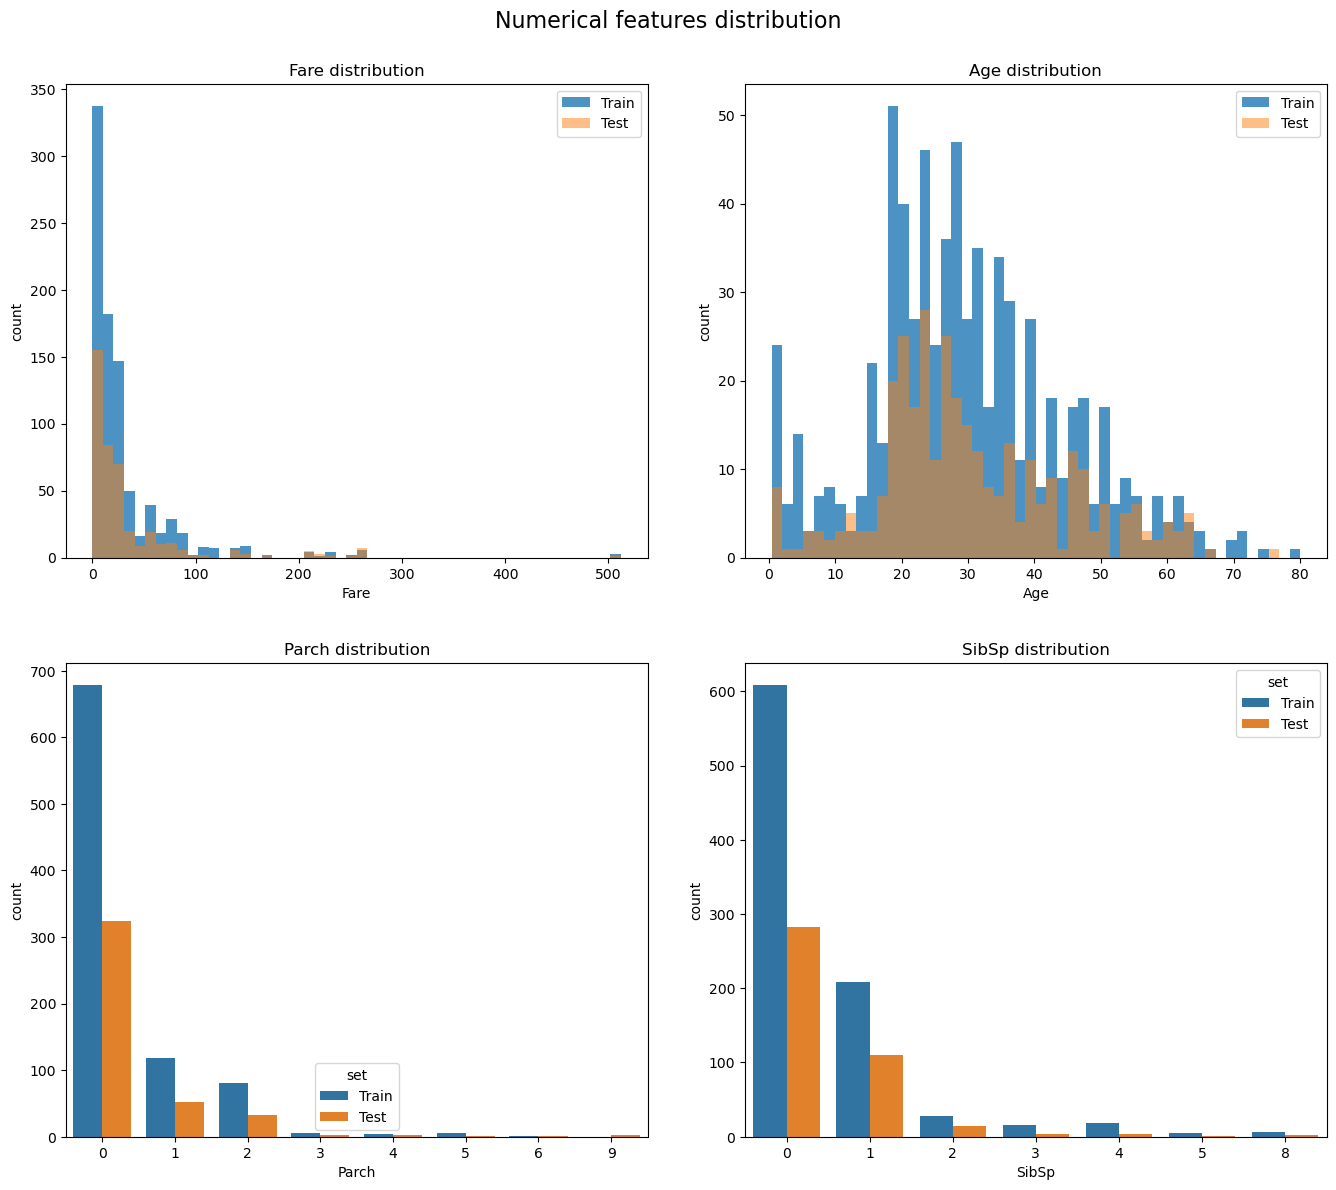

train:
         Fare    Age  Parch  SibSp
count 891.00 714.00 891.00 891.00
mean   32.20  29.70   0.38   0.52
std    49.69  14.53   0.81   1.10
min     0.00   0.42   0.00   0.00
25%     7.91  20.12   0.00   0.00
50%    14.45  28.00   0.00   0.00
75%    31.00  38.00   0.00   1.00
max   512.33  80.00   6.00   8.00 

test:
         Fare    Age  Parch  SibSp
count 417.00 332.00 418.00 418.00
mean   35.63  30.27   0.39   0.45
std    55.91  14.18   0.98   0.90
min     0.00   0.17   0.00   0.00
25%     7.90  21.00   0.00   0.00
50%    14.45  27.00   0.00   0.00
75%    31.50  39.00   0.00   1.00
max   512.33  76.00   9.00   8.00 



In [11]:
plt.figure(figsize=(14,12))
i=1
for col in num_cols:
  plt.subplot(2,2,i)
  # train
  _, bins, _ = plt.hist(df_train[col], alpha=0.8,bins=50, label =['Train'])
  # test
  plt.hist(df_test[col], bins=bins, alpha=0.5, label =['Test'])
  plt.ylabel('count')
  plt.xlabel(col)
  plt.title(col+' distribution')  
  plt.legend()
  i+=1

for col in num_cnt_cols:
  plt.subplot(2,2,i)
    # train
  vc_train = pd.DataFrame(df_train[col].value_counts(sort=False).sort_index().reset_index())
  vc_train['set'] = 'Train'
  
  # test
  vc_test = pd.DataFrame(df_test[col].value_counts(sort=False).sort_index().reset_index())
  vc_test['set'] = 'Test'

  vc = pd.concat([vc_train, vc_test], axis=0)
  sns.barplot(data = vc, x= vc['index'], y= vc[col], hue='set')
  plt.ylabel('count')
  plt.xlabel(col)
  plt.title(col+' distribution')

  i+=1

plt.tight_layout(pad=3)
plt.suptitle('Numerical features distribution', fontsize=16,y=1.01)
plt.show()


for df_tpl in dfs:
  df = df_tpl[1]
  set_ = df_tpl[0]
  print(f'{set_}:\n',df[num_cols + num_cnt_cols].describe(),'\n')

In [12]:
print('We have {} rows with Fare = 0, we will replace it with NaN and inpute them in next section \n\n'.format(len(df_full[df_full.Fare == 0])))
display(df_full[df_full.Fare == 0].head(3))

# update train/test & full
# replace fare = 0 with Nan
for df in dfs:
  df[1].loc[df[1].Fare == 0, 'Fare'] = np.nan

df_full = pd.concat([df_train, df_test], axis = 0).reset_index(drop=True)


We have 17 rows with Fare = 0, we will replace it with NaN and inpute them in next section 




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
179,180,0.00,3,"Leonard, Mr. Lionel",male,36.00,0,0,LINE,0.00,S
263,264,0.00,1,"Harrison, Mr. William",male,40.00,0,0,112059,0.00,S
271,272,1.00,3,"Tornquist, Mr. William Henry",male,25.00,0,0,LINE,0.00,S


**Observations:**
<br>
Numerical features from Train and Test set have similar distribution 
<br>

**Parch & SibSp**
> Most of passengers have 0 PARentsCHildren and 0 SIBlingSPouse => Alone.

**Age**
>Most passengers are in 15-35 age range. The average Age is around 30 years.


**Fare**
> We have a *data integrity problem* with some Fare values equal to 0:
 >>1. we replaced it with NaN 
 >>2. will inpute them in next section 

#### Numerical features distribution / Target

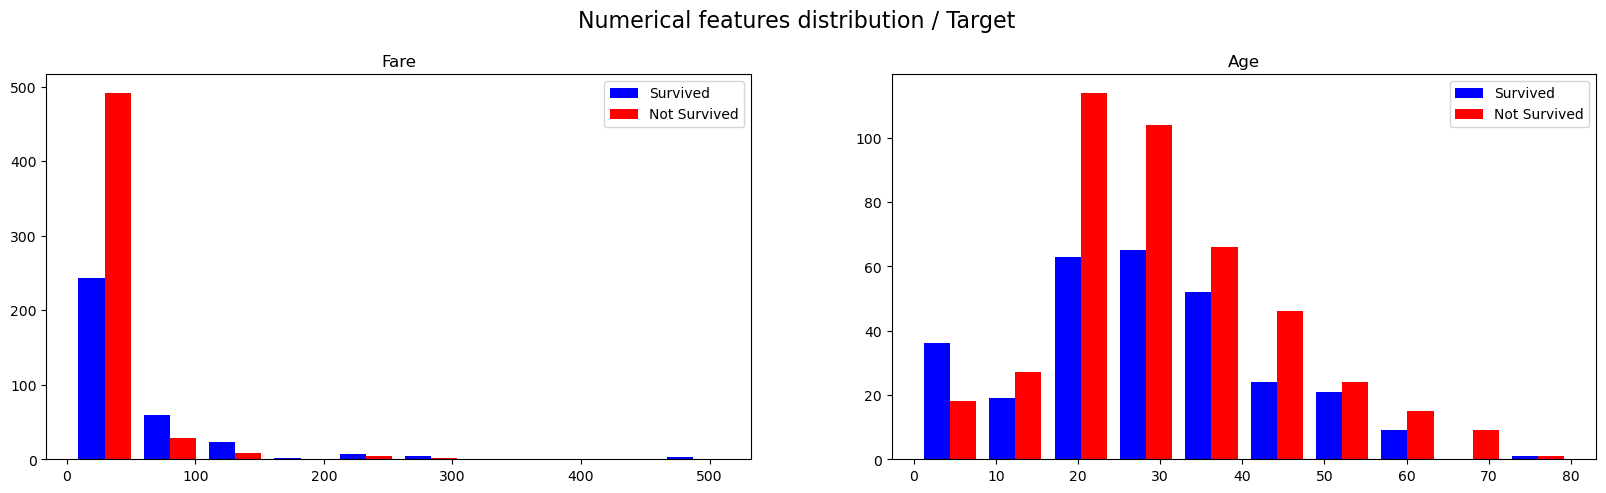

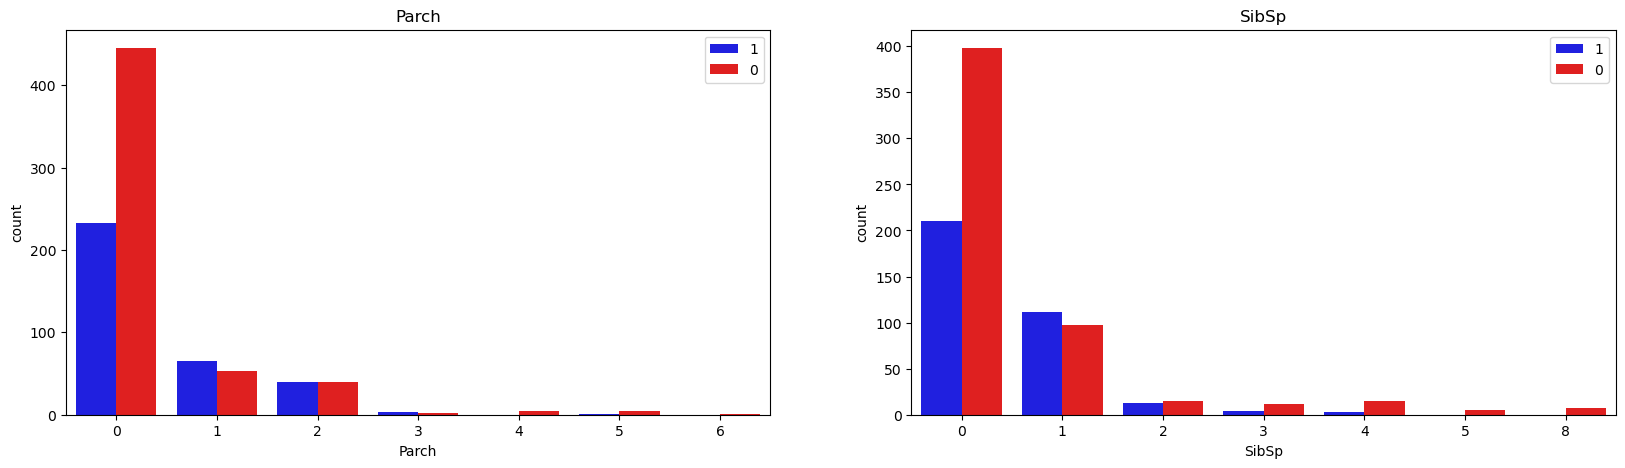

	Survival rate

Fare
(4.012, 54.844]      0.33
(54.844, 105.676]    0.67
(105.676, 156.508]   0.74
(156.508, 207.339]   1.00
(207.339, 258.171]   0.64
(258.171, 309.003]   0.67
(309.003, 359.834]    NaN
(359.834, 410.666]    NaN
(410.666, 461.498]    NaN
(461.498, 512.329]   1.00
Name: Survived, dtype: float64 

Age
(0.42, 8.378]      0.66
(8.378, 16.336]    0.41
(16.336, 24.294]   0.36
(24.294, 32.252]   0.38
(32.252, 40.21]    0.44
(40.21, 48.168]    0.34
(48.168, 56.126]   0.47
(56.126, 64.084]   0.38
(64.084, 72.042]   0.00
(72.042, 80.0]     0.50
Name: Survived, dtype: float64 

Parch
0   0.34
1   0.55
2   0.50
3   0.60
4   0.00
5   0.20
6   0.00
Name: Survived, dtype: float64 

SibSp
0   0.35
1   0.54
2   0.46
3   0.25
4   0.17
5   0.00
8   0.00
Name: Survived, dtype: float64 



In [13]:
i=1
f = plt.figure(figsize=(20,5))
df = df_train
survival_rates=[]

for col in num_cols:
  plt.subplot(1,2,i)
  n,bins,patchs = plt.hist([df[col].loc[df['Survived']==1],df[col].loc[df['Survived']==0] ], color =['b','r'], label=['Survived', 'Not Survived'])
  plt.title(col)
  plt.legend()
  i+=1

  # survival rate
  survival_rates.append(pd.concat([pd.cut(df[col], bins), df.Survived], axis=1).groupby([col]).Survived.mean())

i=0
g,sub=plt.subplots(1,2,figsize=(20, 5))

for col in num_cnt_cols:
  sns.countplot(ax=sub[i], x= col, data = df_train, hue = 'Survived',hue_order=[1,0] ,  palette =['b','r'])
  sub[i].legend(loc='upper right')
  sub[i].set_title(col)
  i+=1

f.suptitle('Numerical features distribution / Target', fontsize=16,y=1.01)
plt.show()

# Numerical features Survival rate / bins
print('\tSurvival rate\n')
for serie in survival_rates:
  print(serie, '\n')

for col in num_cnt_cols:
  print(df.groupby([col]).Survived.mean(), '\n')

**Observations:**

- Lowcost passengers, Alone passenger and big famillies have the worst survival rate we will go further below using Pclass variable

- Prenium passengers, Children, old (>70) passengers  and small famillies have higher survival rate





#### Nominal features distribution

In [14]:
df_train[nominal_cols].describe(include='O')

,Name,Ticket,Embarked,Sex
count,891,891,889,891
unique,891,681,3,2
top,"Braund, Mr. Owen Harris",347082,S,male
freq,1,7,644,577


We have too many unique values to plot the distribution of **Name** and **Ticket**

In [15]:
# overview of 'Name','Ticket'
df_train[['Name','Ticket']].head()

,Name,Ticket
0,"Braund, Mr. Owen Harris",A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599
2,"Heikkinen, Miss. Laina",STON/O2. 3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803
4,"Allen, Mr. William Henry",373450


**Distribution of Embarked and Sex**

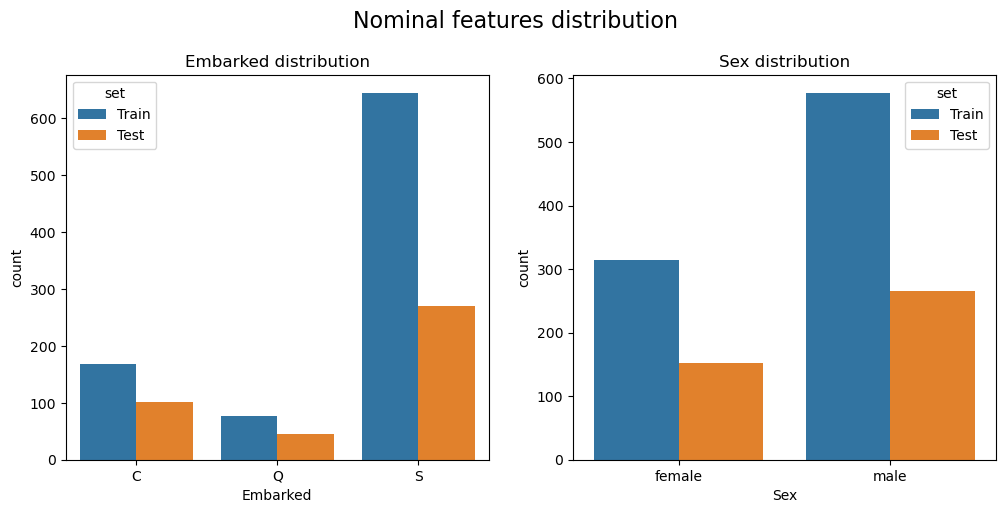

In [16]:
t = df_train[nominal_cols].nunique()<10

plt.figure(figsize=(12,5))
i=1
for col in t[t].index:
  plt.subplot(1,2,i)
    # train
  vc_train = pd.DataFrame(df_train[col].value_counts(sort=False).sort_index().reset_index())
  vc_train['set'] = 'Train'
  
  # test
  vc_test = pd.DataFrame(df_test[col].value_counts(sort=False).sort_index().reset_index())
  vc_test['set'] = 'Test'

  vc = pd.concat([vc_train, vc_test], axis=0)
  sns.barplot(data = vc, x= vc['index'], y= vc[col], hue='set')
  plt.ylabel('count')
  plt.xlabel(col)
  plt.title(col+' distribution')

  i+=1

plt.suptitle('Nominal features distribution', fontsize=16,y=1.01)
plt.show()

#### Nominal features distribution / Target

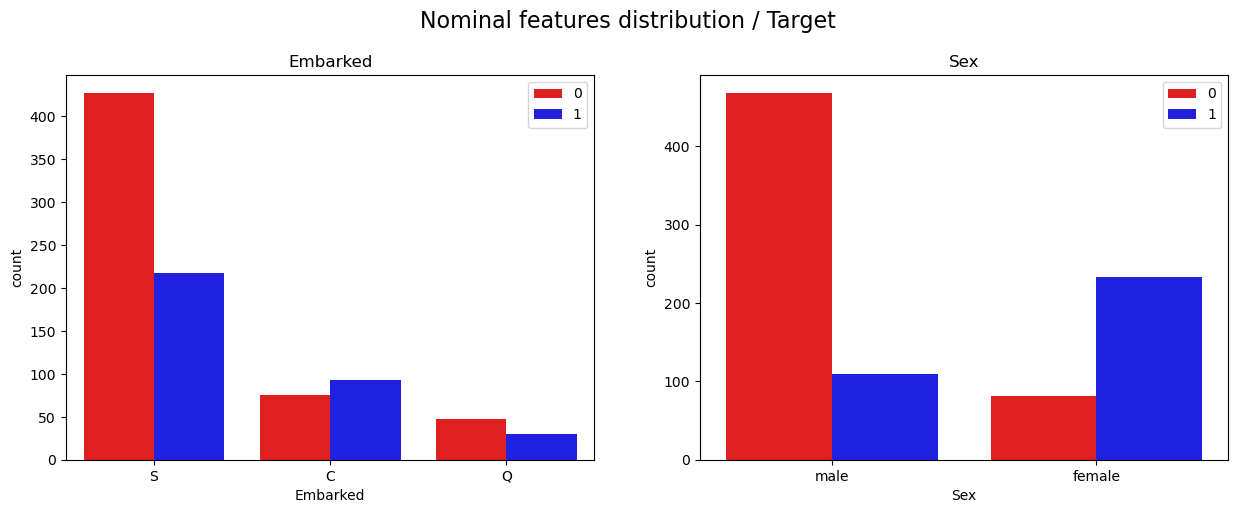

	Survival rate

Embarked
C   0.55
Q   0.39
S   0.34
Name: Survived, dtype: float64 

Sex
female   0.74
male     0.19
Name: Survived, dtype: float64 



In [17]:
f,sub=plt.subplots(1,2,figsize=(15, 5))
i=0

for col in t[t].index:
  sns.countplot(ax=sub[i], x= col, data = df_train, hue = 'Survived',  palette =['r','b'])
  sub[i].legend(loc='upper right')
  sub[i].set_title(col)
  i+=1

plt.suptitle('Nominal features distribution / Target', fontsize=16,y=1.01)
plt.show()

print('\tSurvival rate\n')

for col in t[t].index:
  print(df_train.groupby([col]).Survived.mean(), '\n')

In [18]:
pd.crosstab(df_full['Embarked'],df_full['Pclass'] )

Pclass,1,2,3
Embarked,,,
C,141,28,101
Q,3,7,113
S,177,242,495


**Observations:**

- Male passengers have a terrible survival rate (80% died) and female a great one (74% survived)
-Embarked survival rate is related the Pclass passenger. 
For example Passengers have embarked from C have higher survival rate (55%) because much of them are in first class.



#### Ordinal features distribution

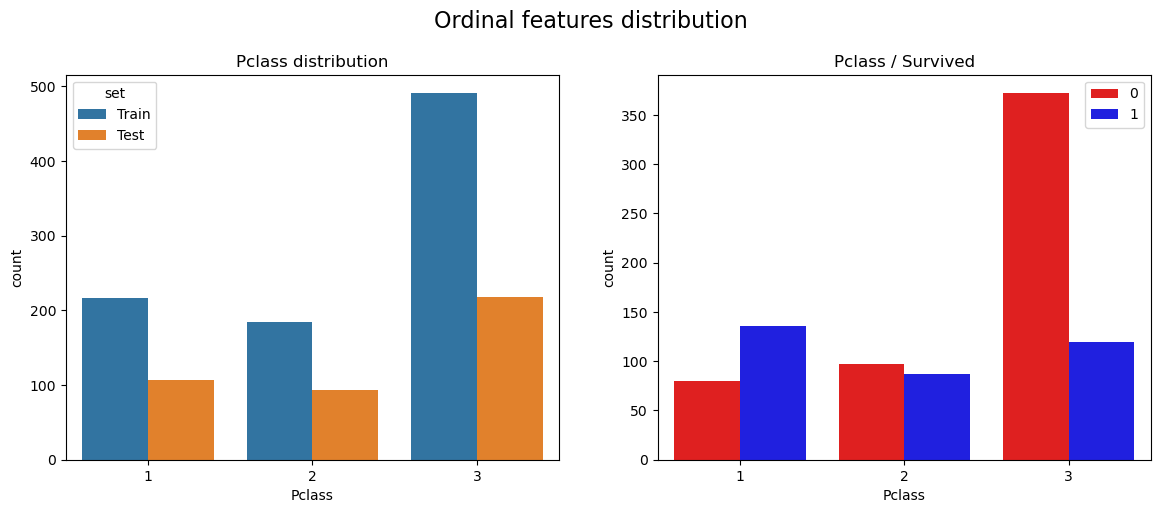

	Survival rate
 Pclass
1   0.63
2   0.47
3   0.24
Name: Survived, dtype: float64


In [19]:
distrib(col = 'Pclass', title='Ordinal features distribution')

Observations:

- Better the Pclass is, greater is the survival rate. It comfirms our observation below on lowcost passenger

# Feature engineering 


Familly size / Connected Survival


#### Familly size

>FamilySize = SibSp + Parch + 1

>>sibsp:	# of siblings / spouses aboard the Titanic	
parch:	# of parents / children aboard the Titanic<br>
\+ 1: is the current passenger

In [20]:
for df in dfs:
  df[1]['FamilySize'] = df[1]['SibSp'] + df[1]['Parch'] +1

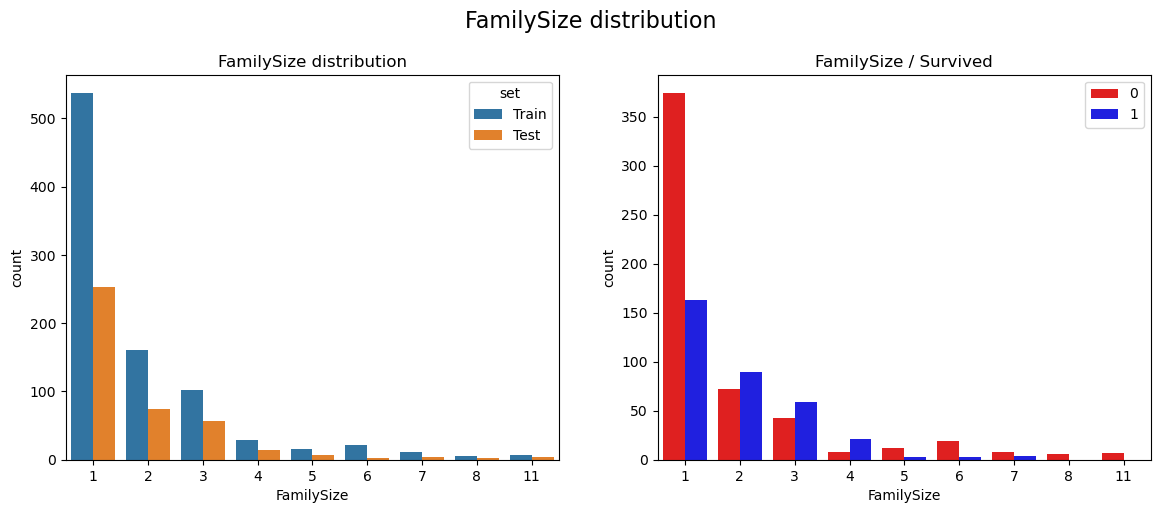

	Survival rate
 FamilySize
1    0.30
2    0.55
3    0.58
4    0.72
5    0.20
6    0.14
7    0.33
8    0.00
11   0.00
Name: Survived, dtype: float64


In [21]:
distrib(col = 'FamilySize')

Observations:

- The survival rate increase with the familly size until 4 and decrease after

#### Familly id


We will try to group famillies


In [22]:
df_test['Survived'] = 9

# Last_Name
for df in dfs:
  df[1]['Last_Name'] = df[1]['Name'].apply(lambda x: str.split(x, ",")[0])


  # extract the second last name
  df[1]['Last_Name_2'] = df[1]['Name'].str.extract('\("*([^\)]*)')
  df[1]['Last_Name_2'] =df[1]['Last_Name_2'].str.extract('([^"]*)')
  df[1]['Last_Name_2'] = df[1]['Last_Name_2'].str.split().str[-1]


df_full = pd.concat([df_train, df_test], axis = 0).sort_values('Name').reset_index(drop=True)


##### Group by ticket / Familly size

People with the same ticket and the same family size are supposed to be in the same family

In [23]:
df_sub_full = df_full[['PassengerId', 'FamilySize', 'Ticket']]

# group by 'Ticket','FamilySize' 
gb_Tick_FamSize = df_sub_full.loc[df_sub_full['FamilySize']>1].groupby(['Ticket','FamilySize'])[['PassengerId']].count()
gb_Tick_FamSize.reset_index(inplace=True)
gb_Tick_FamSize.rename(columns={'PassengerId':'CntPassengerId'}, inplace=True)
gb_Tick_FamSize = pd.DataFrame(gb_Tick_FamSize)
gb_Tick_FamSize.head()

# Families where the group by count = Family size
fam_id_table = gb_Tick_FamSize.loc[gb_Tick_FamSize['FamilySize'] == gb_Tick_FamSize['CntPassengerId']]
fam_id_table['Familly_id'] = np.arange(1,len(fam_id_table)+1)
fam_id_table.head()


# join the two table to get family id in the df_full
df_full = df_full.merge(fam_id_table, how='left' ,on=['Ticket', 'FamilySize'])
df_full.drop('CntPassengerId', axis=1, inplace=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id
0,846,0,3,"Abbing, Mr. Anthony",male,42.00,0,0,C.A. 5547,7.55,S,1,Abbing,NaN,NaN
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,13.00,0,2,C.A. 2673,20.25,S,3,Abbott,NaN,114.00
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.00,1,1,C.A. 2673,20.25,S,3,Abbott,NaN,114.00
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.00,1,1,C.A. 2673,20.25,S,3,Abbott,Hunt,114.00
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,16.00,0,0,348125,7.65,S,1,Abelseth,NaN,NaN


##### Group by Last_Name / Familly size / Pclass

People with the same last name, familly size and Pclass are supposed to be in the same family

In [24]:
# group by 'Last_Name', 'FamilySize', 'Pclass'
df_sub_full = df_full[['PassengerId', 'FamilySize','Last_Name','Pclass' ,'Familly_id']]
gb_LastName_FamSize_PCl = df_sub_full.loc[(df_sub_full['FamilySize']>1) & (df_sub_full['Familly_id'].isnull())].groupby(['Last_Name', 'FamilySize', 'Pclass']).count()
gb_LastName_FamSize_PCl.reset_index(inplace=True)
gb_LastName_FamSize_PCl.drop([ 'Familly_id'], axis =1, inplace=True)
gb_LastName_FamSize_PCl.rename(columns={'PassengerId':'CntPassengerId'}, inplace=True)
gb_LastName_FamSize_PCl.head()

# Families where the group by count = Family size
fam_id_table_2 = gb_LastName_FamSize_PCl.loc[gb_LastName_FamSize_PCl['FamilySize'] == gb_LastName_FamSize_PCl['CntPassengerId']]
fam_id_table_2['Familly_id'] = np.arange(len(fam_id_table)+1, len(fam_id_table)+ len(fam_id_table_2)+1)
fam_id_table_2.head()


# join
df_full = df_full.merge(fam_id_table_2, how='left' ,on=['Last_Name', 'FamilySize', 'Pclass'])
df_full.drop('CntPassengerId', axis=1, inplace=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y
0,846,0,3,"Abbing, Mr. Anthony",male,42.00,0,0,C.A. 5547,7.55,S,1,Abbing,NaN,NaN,NaN
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,13.00,0,2,C.A. 2673,20.25,S,3,Abbott,NaN,114.00,NaN
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.00,1,1,C.A. 2673,20.25,S,3,Abbott,NaN,114.00,NaN
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.00,1,1,C.A. 2673,20.25,S,3,Abbott,Hunt,114.00,NaN
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,16.00,0,0,348125,7.65,S,1,Abelseth,NaN,NaN,NaN


##### Group by Last_Name / Ticket

People with the same last name, and *close* ticket number are supposed to be in the same familly.

> For example people with 'Vander Planke' last name have tickets 345763 and 345764. We suppose they are in the same familly.

In [25]:
df_full.loc[(df_full.Last_Name == 'Vander Planke')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y
1216,39,0,3,"Vander Planke, Miss. Augusta Maria",female,18.00,2,0,345764,18.00,S,3,Vander Planke,NaN,NaN,NaN
1217,1037,9,3,"Vander Planke, Mr. Julius",male,31.00,3,0,345763,18.00,S,4,Vander Planke,NaN,NaN,NaN
1218,334,0,3,"Vander Planke, Mr. Leo Edmondus",male,16.00,2,0,345764,18.00,S,3,Vander Planke,NaN,NaN,NaN
1219,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.00,1,0,345763,18.00,S,2,Vander Planke,Vandemoortele,NaN,NaN


In [26]:
# create prefix ticket features for the group by
df_full['pref_Ticket'] = df_full.Ticket.map(lambda t: t[:-1])

In [27]:
# group by 'Last_Name','pref_Ticket'
df_sub_full = df_full[['PassengerId', 'FamilySize','Last_Name','pref_Ticket' ,'Familly_id_x', 'Familly_id_y']]
gb_LastName_Ticket = df_sub_full.loc[(df_sub_full['FamilySize'] >1) & (df_sub_full['Familly_id_x'].isnull())& (df_sub_full['Familly_id_y'].isnull())].groupby(['Last_Name','pref_Ticket']).count()
gb_LastName_Ticket.reset_index(inplace=True)
gb_LastName_Ticket.drop(['FamilySize','Familly_id_x', 'Familly_id_y'], axis =1, inplace=True)
gb_LastName_Ticket.rename(columns={'PassengerId':'CntPassengerId'}, inplace=True)
gb_LastName_Ticket.loc[gb_LastName_Ticket.CntPassengerId!=1].head()


# Families where the group by count = Family size
fam_id_table_3 = gb_LastName_Ticket.loc[gb_LastName_Ticket.CntPassengerId!=1]
fam_id_table_3['Familly_id_z'] = np.arange(len(fam_id_table)+len(fam_id_table_2)+1, len(fam_id_table)+ len(fam_id_table_2)+ len(fam_id_table_3)+1)
fam_id_table_3.head()

# join 
df_full = df_full.merge(fam_id_table_3, how='left' ,on=['Last_Name','pref_Ticket'])
df_full.drop('CntPassengerId', axis=1, inplace=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
0,846,0,3,"Abbing, Mr. Anthony",male,42.00,0,0,C.A. 5547,7.55,S,1,Abbing,NaN,NaN,NaN,C.A. 554,NaN
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,13.00,0,2,C.A. 2673,20.25,S,3,Abbott,NaN,114.00,NaN,C.A. 267,NaN
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.00,1,1,C.A. 2673,20.25,S,3,Abbott,NaN,114.00,NaN,C.A. 267,NaN
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.00,1,1,C.A. 2673,20.25,S,3,Abbott,Hunt,114.00,NaN,C.A. 267,NaN
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,16.00,0,0,348125,7.65,S,1,Abelseth,NaN,NaN,NaN,34812,NaN


In [28]:
# familly_not_found
familly_not_found_df = df_full.loc[(df_full.FamilySize > 1)&(df_full.Familly_id_x.isna())&(df_full.Familly_id_y.isna())&(df_full.Familly_id_z.isna())].reset_index()
familly_not_found_df.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
0,12,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.00,1,0,7546,9.47,S,2,Ahlin,Larsson,NaN,NaN,754,NaN
1,29,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.00,1,0,350046,7.85,S,2,Andersen-Jensen,NaN,NaN,NaN,35004,NaN
2,34,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.00,4,2,3101281,7.92,S,7,Andersson,NaN,NaN,NaN,310128,NaN
3,35,1106,9,3,"Andersson, Miss. Ida Augusta Margareta",female,38.00,4,2,347091,7.78,S,7,Andersson,NaN,NaN,NaN,34709,NaN
4,50,572,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.00,2,0,11769,51.48,S,3,Appleton,Lamson,NaN,NaN,1176,NaN


##### Familly_id by hand

We hand inspect the last passengers with untraceable families

In [29]:
# Lamson family same second last name
familly_not_found_df = df_full.loc[(df_full.FamilySize > 1)&(df_full.Familly_id_x.isna())&(df_full.Familly_id_y.isna())&(df_full.Familly_id_z.isna())].reset_index()
familly_not_found_df.loc[familly_not_found_df.Last_Name_2 == 'Lamson']

passenger_ids = familly_not_found_df.loc[familly_not_found_df.Last_Name_2 == 'Lamson', 'PassengerId']
new_fam_id =  max(df_full[['Familly_id_x','Familly_id_y','Familly_id_z']].fillna(0).apply(sum, axis=1))+1
df_full.loc[df_full['PassengerId'].isin(list(passenger_ids)), 'Familly_id_z'] = new_fam_id


# update familly_not_found_df
familly_not_found_df = df_full.loc[(df_full.FamilySize > 1)&(df_full.Familly_id_x.isna())&(df_full.Familly_id_y.isna())&(df_full.Familly_id_z.isna())].reset_index()


In [30]:
# passenger with the same last name of an existing family will be add to this family 
for last_name in familly_not_found_df.Last_Name.unique():

  t= df_full.loc[(df_full.Last_Name == last_name) & (df_full.FamilySize >1)]
  q = t[['Familly_id_x','Familly_id_y','Familly_id_z']].fillna(0).apply(sum, axis=1)

  unique_id = q.nunique()
  fill_id = max(q)

  if len(t)>2 and unique_id == 2:

    df_full.loc[(df_full.Last_Name == last_name) & (df_full.FamilySize >1), 'Familly_id_x'] = fill_id
    
    display(t)
    print('\n\n')



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
31,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.00,4,2,347082,31.27,S,7,Andersson,NaN,83.00,NaN,34708,NaN
32,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.00,4,2,347082,31.27,S,7,Andersson,NaN,83.00,NaN,34708,NaN
33,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.00,4,2,347082,31.27,S,7,Andersson,NaN,83.00,NaN,34708,NaN
34,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.00,4,2,3101281,7.92,S,7,Andersson,NaN,NaN,NaN,310128,NaN
35,1106,9,3,"Andersson, Miss. Ida Augusta Margareta",female,38.00,4,2,347091,7.78,S,7,Andersson,NaN,NaN,NaN,34709,NaN
36,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.00,4,2,347082,31.27,S,7,Andersson,NaN,83.00,NaN,34708,NaN
37,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.00,4,2,347082,31.27,S,7,Andersson,NaN,83.00,NaN,34708,NaN
38,14,0,3,"Andersson, Mr. Anders Johan",male,39.00,1,5,347082,31.27,S,7,Andersson,NaN,83.00,NaN,34708,NaN
41,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.00,1,5,347082,31.27,S,7,Andersson,Brogren,83.00,NaN,34708,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
341,545,0,1,"Douglas, Mr. Walter Donald",male,50.00,1,0,PC 17761,106.42,C,2,Douglas,NaN,139.00,NaN,PC 1776,NaN
342,1076,9,1,"Douglas, Mrs. Frederick Charles (Mary Helene B...",female,27.00,1,1,PC 17558,247.52,C,3,Douglas,Baxter,NaN,NaN,PC 1755,NaN
343,1131,9,1,"Douglas, Mrs. Walter Donald (Mahala Dutton)",female,48.00,1,0,PC 17761,106.42,C,2,Douglas,Dutton,139.00,NaN,PC 1776,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
413,661,1,1,"Frauenthal, Dr. Henry William",male,50.00,2,0,PC 17611,133.65,S,3,Frauenthal,NaN,NaN,NaN,PC 1761,NaN
414,1296,9,1,"Frauenthal, Mr. Isaac Gerald",male,43.00,1,0,17765,27.72,C,2,Frauenthal,NaN,NaN,160.00,1776,NaN
415,335,1,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.65,S,2,Frauenthal,Heinsheimer,NaN,160.00,PC 1761,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
490,861,0,3,"Hansen, Mr. Claus Peter",male,41.00,2,0,350026,14.11,S,3,Hansen,NaN,NaN,NaN,35002,NaN
491,705,0,3,"Hansen, Mr. Henrik Juul",male,26.00,1,0,350025,7.85,S,2,Hansen,NaN,NaN,163.00,35002,NaN
493,1201,9,3,"Hansen, Mrs. Claus Peter (Jennie L Howard)",female,45.00,1,0,350026,14.11,S,2,Hansen,Howard,NaN,163.00,35002,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
801,246,0,1,"Minahan, Dr. William Edward",male,44.00,2,0,19928,90.00,Q,3,Minahan,NaN,NaN,NaN,1992,NaN
802,413,1,1,"Minahan, Miss. Daisy E",female,33.00,1,0,19928,90.00,Q,2,Minahan,NaN,32.00,NaN,1992,NaN
803,1303,9,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.00,1,0,19928,90.00,Q,2,Minahan,Thorpe,32.00,NaN,1992,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
857,216,1,1,"Newell, Miss. Madeleine",female,31.00,1,0,35273,113.28,C,2,Newell,NaN,90.00,NaN,3527,NaN
858,394,1,1,"Newell, Miss. Marjorie",female,23.00,1,0,35273,113.28,C,2,Newell,NaN,90.00,NaN,3527,NaN
859,660,0,1,"Newell, Mr. Arthur Webster",male,58.00,0,2,35273,113.28,C,3,Newell,NaN,NaN,NaN,3527,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
1177,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.52,C,2,Thomas,NaN,NaN,169.00,262,NaN
1178,1025,9,3,"Thomas, Mr. Charles P",male,NaN,1,0,2621,6.44,C,2,Thomas,NaN,NaN,169.00,262,NaN
1181,996,9,3,"Thomas, Mrs. Alexander (Thamine Thelma"")""",female,16.00,1,1,2625,8.52,C,3,Thomas,Thelma,NaN,NaN,262,NaN


In [31]:
familly_not_found_df = df_full.loc[(df_full.FamilySize > 1)&(df_full.Familly_id_x.isna())&(df_full.Familly_id_y.isna())&(df_full.Familly_id_z.isna())].reset_index()
familly_not_found_df

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
0,12,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.00,1,0,7546,9.47,S,2,Ahlin,Larsson,NaN,NaN,754,NaN
1,29,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.00,1,0,350046,7.85,S,2,Andersen-Jensen,NaN,NaN,NaN,35004,NaN
2,416,540,1,1,"Frolicher, Miss. Hedwig Margaritha",female,22.00,0,2,13568,49.50,C,3,Frolicher,NaN,NaN,NaN,1356,NaN
3,539,1130,9,2,"Hiltunen, Miss. Marta",female,18.00,1,1,250650,13.00,S,3,Hiltunen,NaN,NaN,NaN,25065,NaN
4,591,722,0,3,"Jensen, Mr. Svend Lauritz",male,17.00,1,0,350048,7.05,S,2,Jensen,NaN,NaN,NaN,35004,NaN
5,713,665,1,3,"Lindqvist, Mr. Eino William",male,20.00,1,0,STON/O 2. 3101285,7.92,S,2,Lindqvist,NaN,NaN,NaN,STON/O 2. 310128,NaN
6,850,274,0,1,"Natsch, Mr. Charles H",male,37.00,0,1,PC 17596,29.70,C,2,Natsch,NaN,NaN,NaN,PC 1759,NaN
7,860,137,1,1,"Newsom, Miss. Helen Monypeny",female,19.00,0,2,11752,26.28,S,3,Newsom,NaN,NaN,NaN,1175,NaN
8,953,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.00,1,0,347083,7.78,S,2,Persson,NaN,NaN,NaN,34708,NaN
9,963,443,0,3,"Petterson, Mr. Johan Emil",male,25.00,1,0,347076,7.78,S,2,Petterson,NaN,NaN,NaN,34707,NaN


In [32]:
# we try to find connections btw last_name and Last_Name_2

names = list(zip(familly_not_found_df.Last_Name, familly_not_found_df.Last_Name_2))

for last_name_tp in names:

  # print(last_name_tp[1])

  t= df_full.loc[((df_full.Last_Name == last_name_tp[1]) | (df_full.Last_Name_2 == last_name_tp[1])) & (df_full.FamilySize >1)]
  if len(t)>1:
    display(t)
    print('\n')

  t2= df_full.loc[((df_full.Last_Name == last_name_tp[0]) | (df_full.Last_Name_2 == last_name_tp[0])) & (df_full.FamilySize >1)]
  if len(t2)>1:
    display(t2)
    print('\n')

  t3= df_full.loc[((df_full.Last_Name == last_name_tp[0]) | (df_full.Last_Name_2 == last_name_tp[1])) & (df_full.FamilySize >1)]
  if len(t3)>1:
    display(t3)
    print('\n')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
544,896,9,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,S,3,Hirvonen,Lindqvist,NaN,NaN,310129,180.00
713,665,1,3,"Lindqvist, Mr. Eino William",male,20.00,1,0,STON/O 2. 3101285,7.92,S,2,Lindqvist,NaN,NaN,NaN,STON/O 2. 310128,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
712,1251,9,3,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...",female,30.00,1,0,349910,15.55,S,2,Lindell,Persson,89.00,NaN,34991,NaN
953,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.00,1,0,347083,7.78,S,2,Persson,NaN,NaN,NaN,34708,NaN
1156,252,0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.00,1,1,347054,10.46,S,3,Strom,Persson,NaN,NaN,34705,189.00


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
548,775,1,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.00,1,3,29105,23.00,S,5,Hocking,Needs,NaN,NaN,2910,181.00
1268,893,9,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,S,2,Wilkes,Needs,NaN,NaN,36327,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,Familly_id_x,Familly_id_y,pref_Ticket,Familly_id_z
548,775,1,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.00,1,3,29105,23.00,S,5,Hocking,Needs,NaN,NaN,2910,181.00
1268,893,9,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,S,2,Wilkes,Needs,NaN,NaN,36327,NaN


In [33]:
# update by hand following the cell above
df_full.loc[  (df_full['Last_Name'] == 'Lindqvist'), 'Familly_id_x'] = 180
df_full.loc[  (df_full['Last_Name'] == 'Persson'), 'Familly_id_x'] = 189

# update familly_not_found_df
familly_not_found_df = df_full.loc[(df_full.FamilySize > 1)&(df_full.Familly_id_x.isna())&(df_full.Familly_id_y.isna())&(df_full.Familly_id_z.isna())].reset_index()

print(f'There are {len(familly_not_found_df)} people without familly_id')

There are 10 people without familly_id


In [34]:
# test the Familly_id
assert set(df_full['Familly_id_x']).intersection(set(df_full['Familly_id_y']), set(df_full['Familly_id_z'])) == set(), 'Duplicate Familly_id indexing !!!'

# create Familly_id
df_full['Familly_id'] = df_full[['Familly_id_x','Familly_id_y','Familly_id_z']].fillna(0).apply(sum, axis=1)

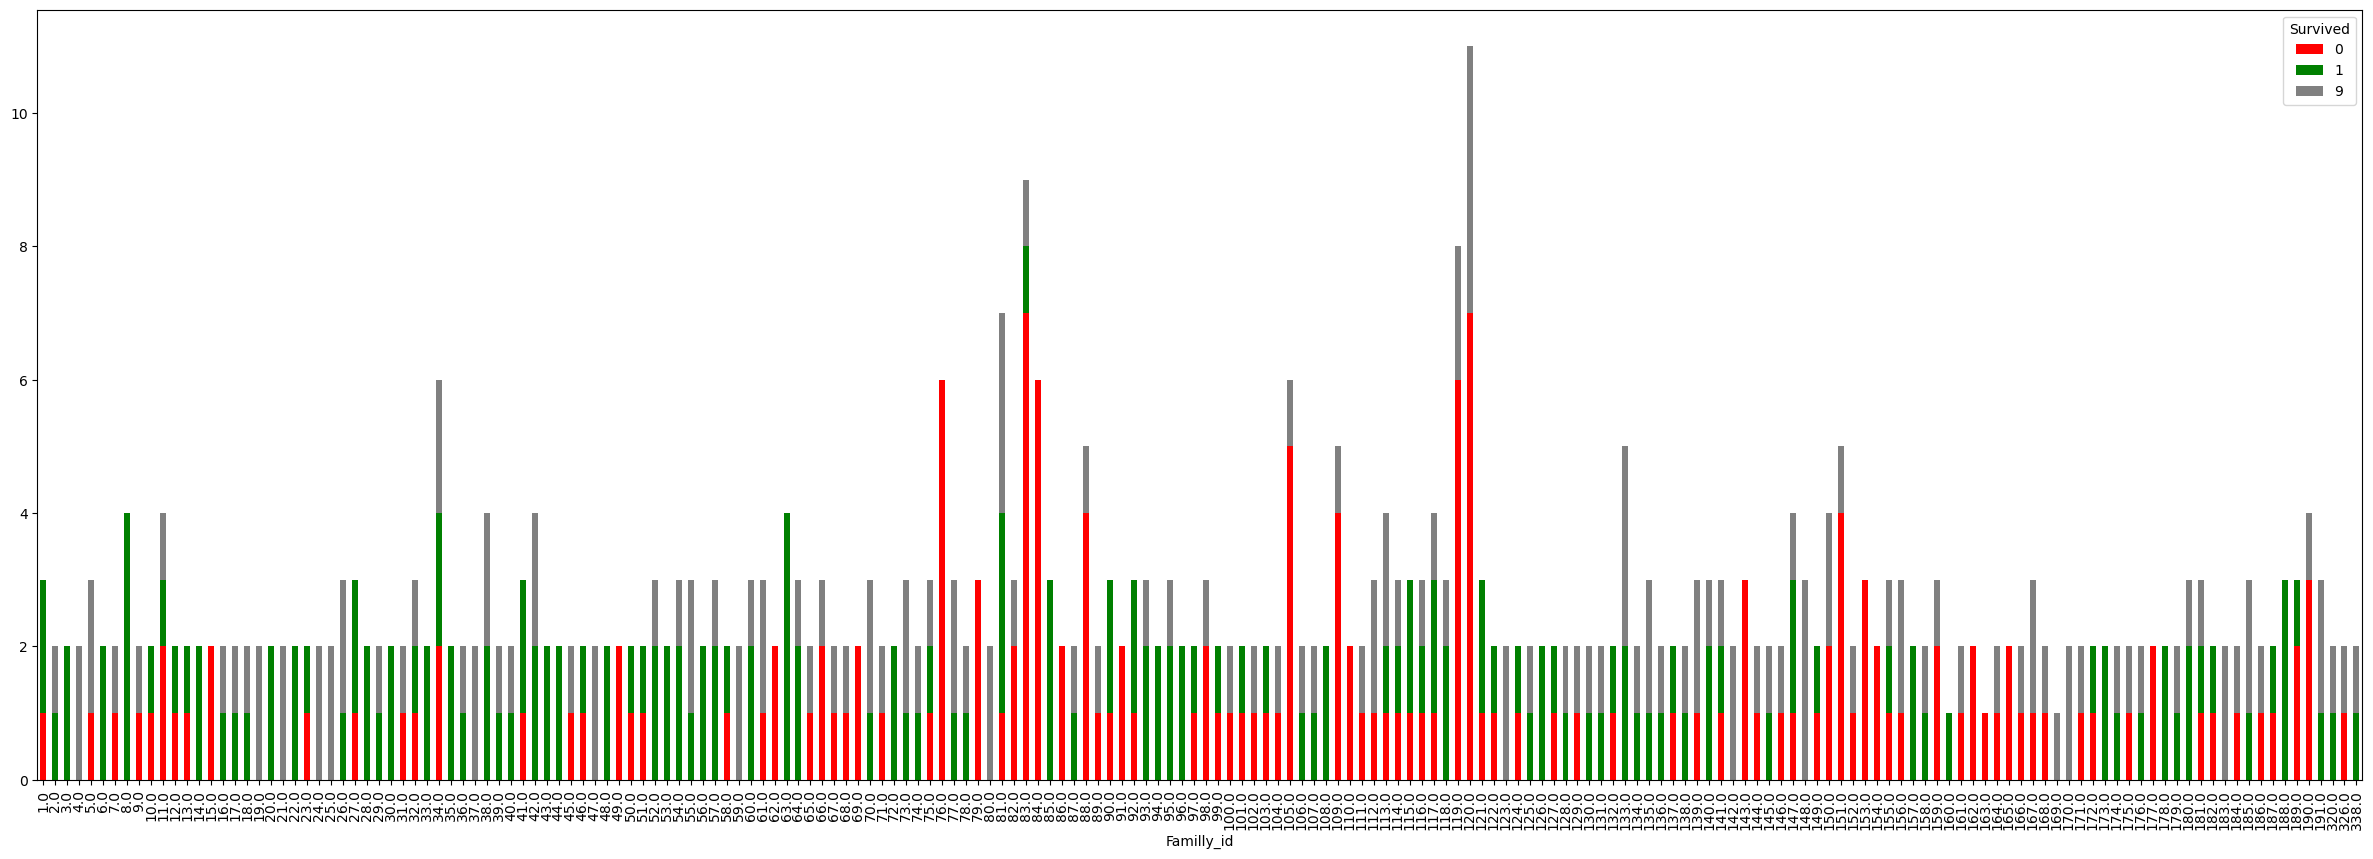

In [35]:
# plot
pd.crosstab(df_full['Familly_id'], df_full['Survived']).drop([0]).plot(kind='bar', stacked=True, color=['r','g','grey'], figsize=(30,10))
plt.show()

#### Connected survival


In [36]:
df_full['Connected_Survival'] = df_full.groupby(['Familly_id'])['Survived'].transform('median')

# Alone
df_full.loc[df_full['Familly_id']==0, 'Connected_Survival'] = 0.5
# median to adjust
df_full.loc[df_full['Connected_Survival']> 4 , 'Connected_Survival'] = 0.5

# update df_full
df_full.drop(['Familly_id_x', 'Familly_id_y', 'Familly_id_z'], axis=1, inplace= True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2,pref_Ticket,Familly_id,Connected_Survival
0,846,0,3,"Abbing, Mr. Anthony",male,42.00,0,0,C.A. 5547,7.55,S,1,Abbing,NaN,C.A. 554,0.00,0.50
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,13.00,0,2,C.A. 2673,20.25,S,3,Abbott,NaN,C.A. 267,114.00,1.00
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.00,1,1,C.A. 2673,20.25,S,3,Abbott,NaN,C.A. 267,114.00,1.00
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.00,1,1,C.A. 2673,20.25,S,3,Abbott,Hunt,C.A. 267,114.00,1.00
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,16.00,0,0,348125,7.65,S,1,Abelseth,NaN,34812,0.00,0.50


## Fill NAn

#### Fare

In [37]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Last_Name,Last_Name_2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,S,2,Braund,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C,2,Cumings,Thayer
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,S,1,Heikkinen,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,S,2,Futrelle,Peel
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,S,1,Allen,NaN


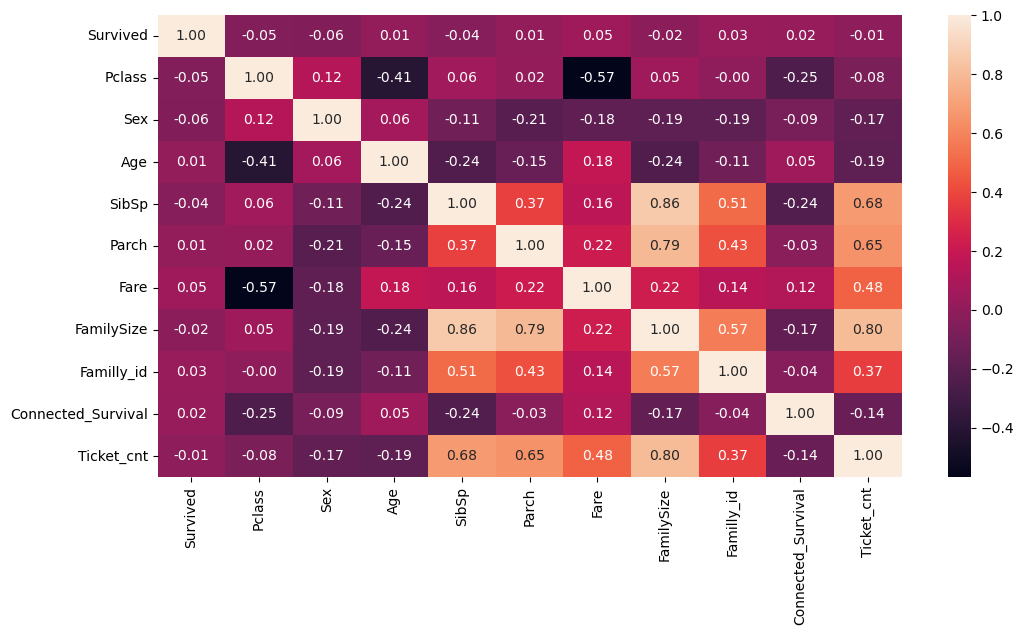

In [38]:
# encode sex to binary
df_full['Sex'] = df_full.Sex.map({'male':1, 'female':0})

# number of passenger with the same ticket number
df_full['Ticket_cnt'] = df_full.groupby('Ticket')['Ticket'].transform('count')

col_to_drop = ['PassengerId', 'Name', 'Ticket', 'Embarked']
plt.figure(figsize=(12,6))
sns.heatmap(df_full.drop(col_to_drop, axis=1).corr() ,annot = True, fmt = '.2f')
plt.show()

According to the correlation graph, fare is correlated to ticket_cnt and pclass features.

The median fare of a male with a third-class ticket and no family is a logical choice to fill the missing value.






In [39]:
med_fare = df_full.groupby(['Pclass','Ticket_cnt']).Fare.median().reset_index()
med_fare.head()

,Pclass,Ticket_cnt,Fare
0,1,1,27.72
1,1,2,59.70
2,1,3,86.50
3,1,4,150.25
4,1,5,211.50


In [40]:
idx = df_full.loc[df_full['Fare'].isnull()].index

for id in idx:
  passengerId,pclass, ticket_cnt = df_full.loc[id, ['PassengerId','Pclass', 'Ticket_cnt']]

  med_fare_fill_na = med_fare.loc[(med_fare['Pclass']==pclass) & (med_fare['Ticket_cnt']==ticket_cnt),'Fare' ].values[0]
  # print(med_fare_fill_na)
  df_full.loc[id, 'Fare'] = med_fare_fill_na

In [41]:
len(df_full.loc[df_full['Fare'].isnull()])

0

#### Age


We will use a model to predict missing Age

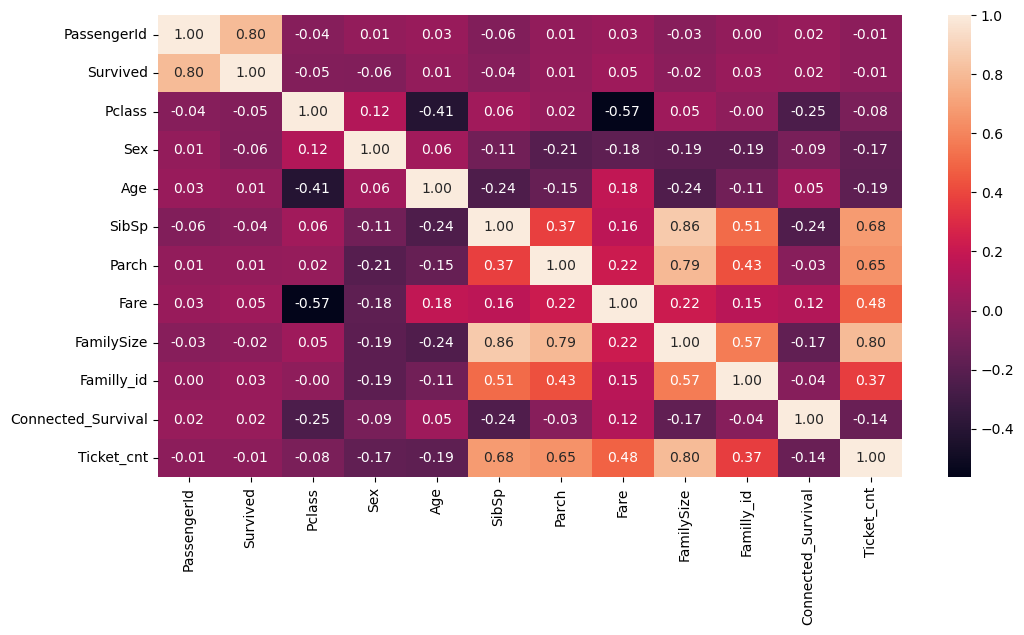

In [42]:
df_full = df_full.sort_values(by='PassengerId').reset_index(drop=True)
# df_full.head()
df_train_test = df_full.copy()

plt.figure(figsize=(12,6))
sns.heatmap(df_train_test.corr() ,annot = True, fmt = '.2f')
plt.show()


In [43]:
col_to_add_after_training = [
 'Embarked',
 'FamilySize',
 'Fare',
 'Name',
 'PassengerId',
 'Sex',
 'Survived',
 'Ticket',
 'Last_Name',
 'Last_Name_2',
 'Ticket_cnt',
 'pref_Ticket',
 'Familly_id',
 'Connected_Survival'
]
 
add_columns_train_test = df_train_test[col_to_add_after_training]

In [44]:
# we drop survived bc of Nan and Familly_id
df_train_test.drop(col_to_add_after_training, axis=1,inplace=True)
df_train_test

,Pclass,Age,SibSp,Parch
0,3,22.00,1,0
1,1,38.00,1,0
2,3,26.00,0,0
3,1,35.00,1,0
4,3,35.00,0,0
...,...,...,...,...
1304,3,NaN,0,0
1305,1,39.00,0,0
1306,3,38.50,0,0
1307,3,NaN,0,0


In [45]:
df_age_null = df_train_test.loc[df_train_test.Age.isnull()]
df_age_notnull = df_train_test.loc[df_train_test.Age.notnull()]

X = df_age_notnull.drop('Age', axis=1)
y = df_age_notnull['Age']

# split data
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X, y, random_state=42)

# test model
reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_age_train, X_age_test, y_age_train, y_age_test)
print(models)

100%|██████████| 42/42 [00:11<00:00,  3.60it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.28       0.29 11.07        0.10
XGBRegressor                                 0.27       0.28 11.17        0.43
RandomForestRegressor                        0.27       0.27 11.18        0.17
BaggingRegressor                             0.26       0.27 11.20        0.03
SVR                                          0.26       0.27 11.21        0.05
ExtraTreesRegressor                          0.26       0.27 11.22        0.12
GaussianProcessRegressor                     0.26       0.27 11.22        0.10
DecisionTreeRegressor                        0.26       0.26 11.26        0.01
MLPRegressor                                 0.25       0.26 11.27        1.23
NuSVR                                        0.25       0.26 11.33        0.10
ExtraTreeRegressor                           0.25   

In [46]:
# GradientBoostingRegressor to predict Age
reg = GradientBoostingRegressor(random_state=42)
X_age_train, X_age_test, y_age_train, y_age_test
reg.fit(X_age_train, y_age_train)
y_pred_age = reg.predict(X_age_test)


print('R^2: ', r2_score(y_age_test, y_pred_age))
print('RMSE: ',mean_squared_error(y_age_test, y_pred_age))

R^2:  0.28909358772214366
RMSE:  122.63453246339776


In [47]:
y_pred_age = reg.predict(df_age_null.drop('Age', axis=1))
df_age_null.Age = y_pred_age

df_full = pd.concat([df_age_notnull,df_age_null], axis = 0).sort_index()
df_full = pd.concat([df_full,add_columns_train_test], axis=1)
df_full.head()

,Pclass,Age,SibSp,Parch,Embarked,FamilySize,Fare,Name,PassengerId,Sex,Survived,Ticket,Last_Name,Last_Name_2,Ticket_cnt,pref_Ticket,Familly_id,Connected_Survival
0,3,22.00,1,0,S,2,7.25,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,Braund,NaN,1,A/5 2117,154.00,0.00
1,1,38.00,1,0,C,2,71.28,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,0,1,PC 17599,Cumings,Thayer,2,PC 1759,130.00,0.50
2,3,26.00,0,0,S,1,7.92,"Heikkinen, Miss. Laina",3,0,1,STON/O2. 3101282,Heikkinen,NaN,1,STON/O2. 310128,0.00,0.50
3,1,35.00,1,0,S,2,53.10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",4,0,1,113803,Futrelle,Peel,2,11380,13.00,0.50
4,3,35.00,0,0,S,1,8.05,"Allen, Mr. William Henry",5,1,0,373450,Allen,NaN,1,37345,0.00,0.50


In [48]:
df_train = df_full.iloc[:len(df_train)]
df_test = df_full.iloc[len(df_train):]
dfs = [('train',df_train), ('test',df_test)]

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              1309 non-null   int64  
 1   Age                 1309 non-null   float64
 2   SibSp               1309 non-null   int64  
 3   Parch               1309 non-null   int64  
 4   Embarked            1307 non-null   object 
 5   FamilySize          1309 non-null   int64  
 6   Fare                1309 non-null   float64
 7   Name                1309 non-null   object 
 8   PassengerId         1309 non-null   int64  
 9   Sex                 1309 non-null   int64  
 10  Survived            1309 non-null   int64  
 11  Ticket              1309 non-null   object 
 12  Last_Name           1309 non-null   object 
 13  Last_Name_2         221 non-null    object 
 14  Ticket_cnt          1309 non-null   int64  
 15  pref_Ticket         1309 non-null   object 
 16  Famill

# Modeling

### Preprocessing

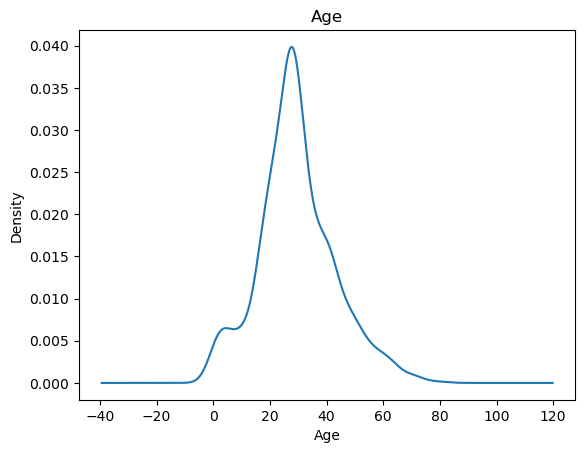

In [49]:
df_train.Age.plot(kind='kde')
plt.title('Age')
plt.xlabel('Age')
plt.show()

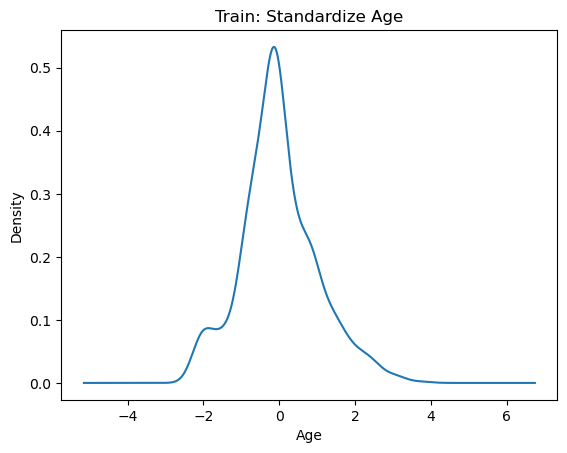

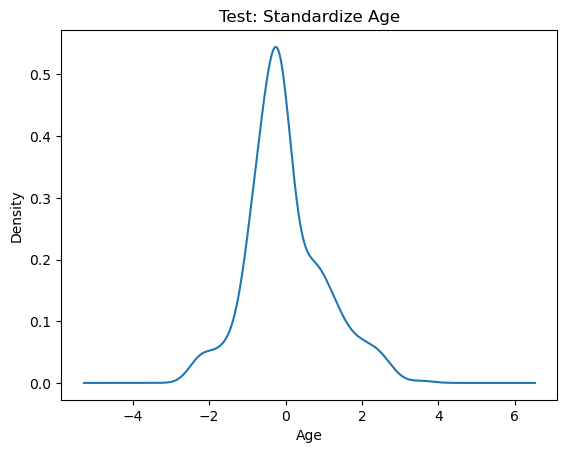

In [50]:
scaler = StandardScaler()

df_train['Age'] = scaler.fit_transform(df_train[['Age']])
df_test['Age'] = scaler.fit_transform(df_test[['Age']])


df_train['Age'].plot(kind='kde')
plt.title('Train: Standardize Age')
plt.xlabel('Age')
plt.show()


df_test['Age'].plot(kind='kde')
plt.title('Test: Standardize Age')
plt.xlabel('Age')
plt.show()

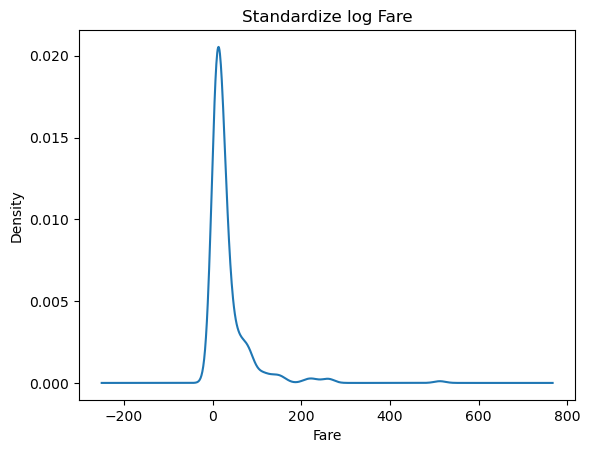

In [51]:
df_train.Fare.plot(kind='kde')
plt.title('Standardize log Fare')
plt.xlabel('Fare')
plt.show()

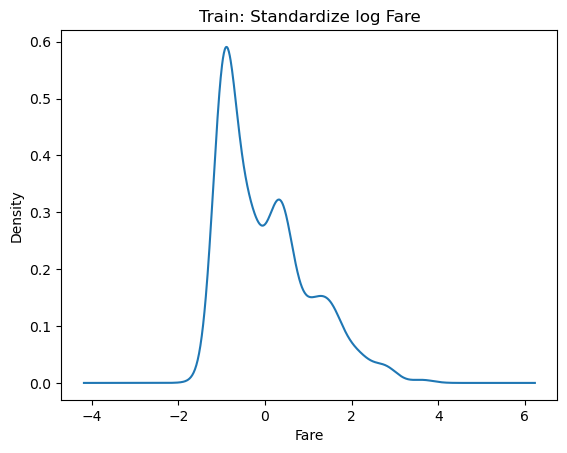

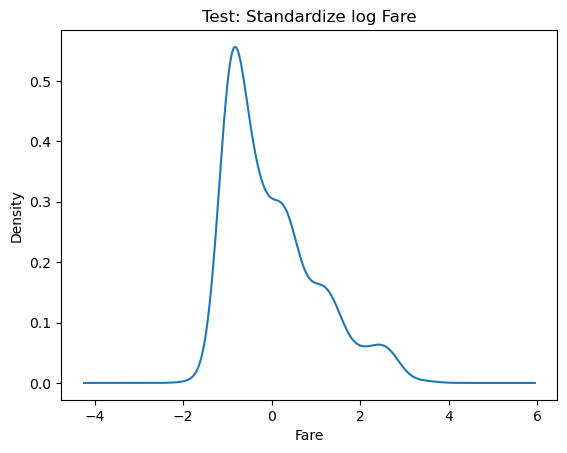

In [52]:
transformer = FunctionTransformer(np.log1p, validate=True)

df_train['Fare'] = scaler.fit_transform(transformer.transform(df_train[['Fare']]))
df_test['Fare'] = scaler.fit_transform(transformer.transform(df_test[['Fare']]))

df_train['Fare'].plot(kind='kde')
plt.title('Train: Standardize log Fare')
plt.xlabel('Fare')
plt.show()


df_test['Fare'].plot(kind='kde')
plt.title('Test: Standardize log Fare')
plt.xlabel('Fare')
plt.show()


### Features selection


We will delete non-relevant columns:

- 'Embarked'& 'Fare'--> related to Pclass

- 'FamilySize', 'Ticket_cnt' --> related to Parch and SibSp

- 'Ticket', 'Family_id' --> related to Connected_Survival

- 'Name', 'Title' --> no Information in it





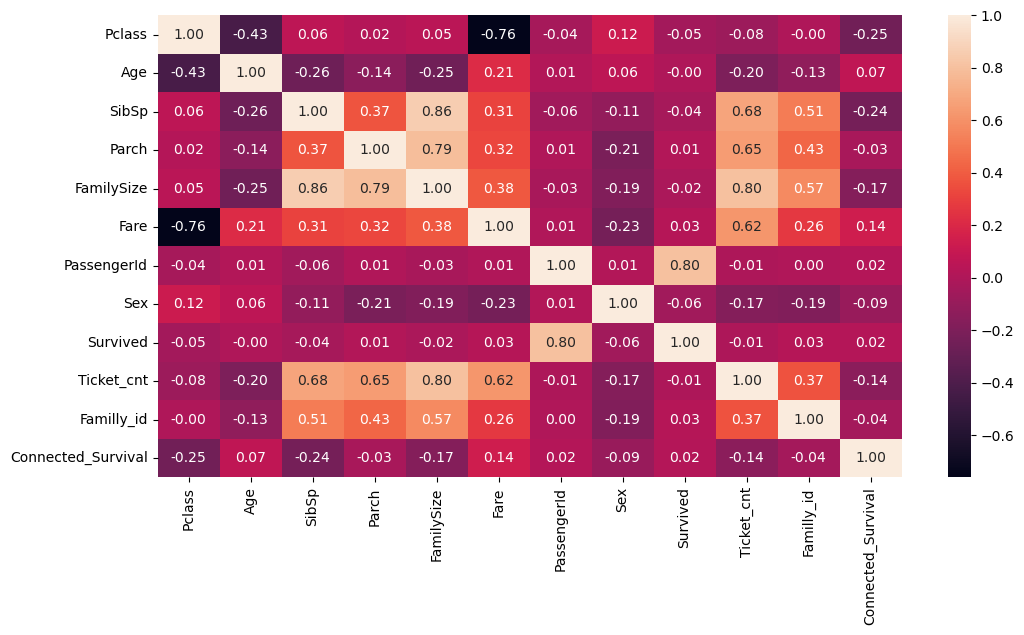

In [53]:
df_full = pd.concat([df_train, df_test], axis = 0).reset_index(drop=True)
plt.figure(figsize=(12,6))
sns.heatmap(df_full.corr() ,annot = True, fmt = '.2f')
plt.show()

We will keep these columns:

['Pclass', 'Age', 'SibSp', 'Parch',  'Sex', 'Connected_Survival']

In [54]:
selected_cols = ['Pclass', 'Age', 'SibSp', 'Parch',  'Sex', 'Connected_Survival', 'Survived']
df_full = df_full[selected_cols]
df_train = df_full.iloc[:len(df_train)]
df_test = df_full.iloc[len(df_train):]
dfs = [('train',df_train), ('test',df_test)]

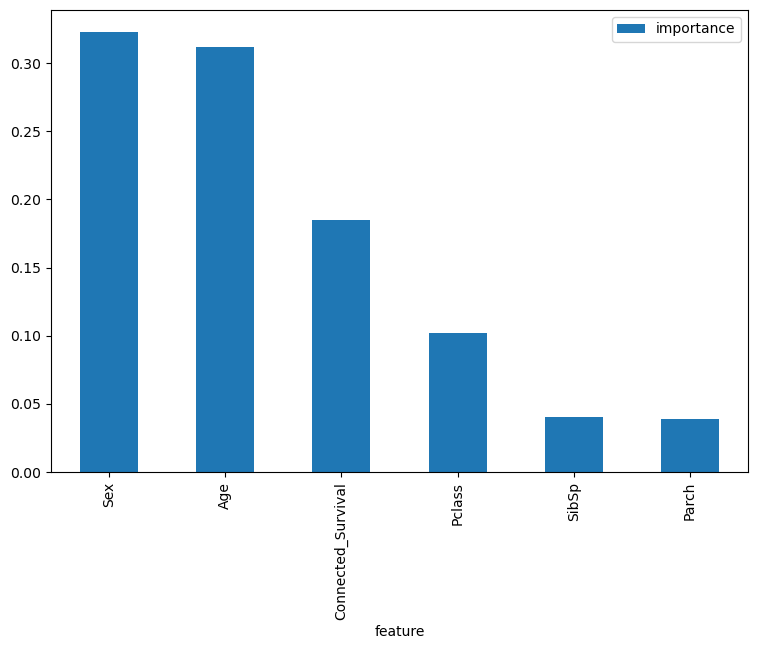

In [55]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=2)


model.fit(X_train,y_train)
importance = pd.DataFrame({'feature':X_train.columns, 'importance': np.round(model.feature_importances_,3)}).sort_values('importance', ascending=False).set_index('feature')
importance.plot(kind='bar', rot=90, figsize=(9,6))
plt.show()

In [56]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred), '\n\n')

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       134
           1       0.80      0.79      0.80        89

    accuracy                           0.84       223
   macro avg       0.83      0.83      0.83       223
weighted avg       0.84      0.84      0.84       223
 




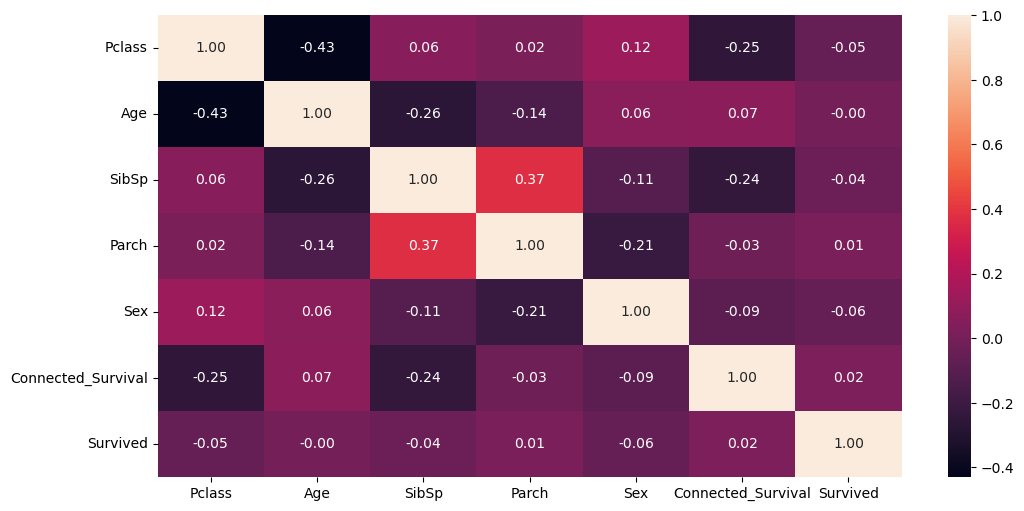

In [57]:
plt.figure(figsize=(12,6))
sns.heatmap(df_full.corr() ,annot = True, fmt = '.2f')
plt.show()

### Model tuning: Grid search


Model selected: LGBMClassifier, XGBClassifier, AdaBoostClassifier, LogisticRegression, SVC, RandomForestClassifier, Decision Tree
,KNeighborsClassifier

In [58]:
def grid_test(model_name, model, parameters, X=X, y=y):
  
  model = GridSearchCV(
    model, 
    parameters, 
    cv=5,
    scoring='accuracy',
)
  
  model.fit(X, y)
  # y_pred = model.predict(X_test)

  # Mean cross-validated score of the best_estimator
  print(model_name, ': ', model.best_score_, '\n')
  # print(classification_report(y_test, y_pred),'\n')


  # return model_name, round(accuracy_score(y_test, y_pred)*100, 2), model.best_estimator_
  return model_name, model.best_score_, model.best_estimator_



In [59]:
# good
lgbm_param = {
    'n_estimators': [5, 10, 15, 25, 50, 100, 125, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [7, 15, 31],
}

# good
log_reg_param = {
    "penalty": ["l1", "l2"],

}

# good
xgb_param = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

# good
ada_param = {
    'n_estimators': [70, 100, 150, 200, 250,300, 400],
    'learning_rate': [0.01, 0.05, 0.1]
}

# good
svc_param = {
    "C": [0.001, 0.01, 0.1, 0.5, 1.],
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}

# good
knn_param = {
    'n_neighbors':[5, 10, 15, 20, 25],
    "weights": ["uniform", "distance"]
}

# good
rf_param = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 13]
}

# good
d_tree_param =  {
    "max_depth": [3, 5, 7, 9, 11, 13]
}

In [60]:
# lgbm = LGBMClassifier(random_state= 42)
log_reg = LogisticRegression(random_state= 42)
xgb = xgboost.XGBClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
svc = SVC(random_state=42)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
d_tree =  DecisionTreeClassifier(random_state=42)

models = [('LogisticRegression',log_reg, log_reg_param), ('XGBClassifier',xgb, xgb_param), 
          ('AdaBoostClassifier',ada, ada_param), ('SVC',svc, svc_param), ('KNeighborsClassifier',knn, knn_param), 
          ('RandomForestClassifier',rf, rf_param), ('Decision Tree',d_tree, d_tree_param) ]

In [61]:
acc_dic={}
model_dic={}

for model in models:
  name,acc, best_model = grid_test(model[0],model[1],model[2])
  acc_dic[name] = acc
  model_dic[name] = best_model

LogisticRegression :  0.8563241478877659 

XGBClassifier :  0.8709120582512083 

AdaBoostClassifier :  0.858571338899002 

SVC :  0.855200552382148 

KNeighborsClassifier :  0.8350260498399346 

RandomForestClassifier :  0.8686648672399724 

Decision Tree :  0.85969493440462 



In [62]:
pd.DataFrame.from_dict(acc_dic, orient='index', columns=['Mean CV Accuracy']).sort_values(by='Mean CV Accuracy', ascending=False)

,Mean CV Accuracy
XGBClassifier,0.87
RandomForestClassifier,0.87
Decision Tree,0.86
AdaBoostClassifier,0.86
LogisticRegression,0.86
SVC,0.86
KNeighborsClassifier,0.84


#### Model testing

In [63]:
pred_dic = {}

for tp in list(model_dic.items()):

  y_pred = tp[1].predict(X_test)

  pred_dic[tp[0]] = y_pred


  print(tp[0])
  print(classification_report(y_pred, y_test), '\n\n')

LogisticRegression
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       144
           1       0.76      0.86      0.81        79

    accuracy                           0.86       223
   macro avg       0.84      0.86      0.85       223
weighted avg       0.86      0.86      0.86       223
 


XGBClassifier
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       143
           1       0.80      0.89      0.84        80

    accuracy                           0.88       223
   macro avg       0.87      0.88      0.87       223
weighted avg       0.88      0.88      0.88       223
 


AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       141
           1       0.80      0.87      0.83        82

    accuracy                           0.87       223
   macro avg       0.86      0.87      0.86       223
weighted avg    



**Aggregate all models predictions**

In [64]:
df_pred = pd.DataFrame(pred_dic)
df_pred.head()

,LogisticRegression,XGBClassifier,AdaBoostClassifier,SVC,KNeighborsClassifier,RandomForestClassifier,Decision Tree
0,0,1,1,1,1,1,1
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1


In [65]:
y_pred = np.round(df_pred.apply(sum, axis=1) / df_pred.shape[1]).astype(int)
print(classification_report(y_pred, y_test), '\n\n')

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       143
           1       0.80      0.89      0.84        80

    accuracy                           0.88       223
   macro avg       0.87      0.88      0.87       223
weighted avg       0.88      0.88      0.88       223
 




**Deep Learning**

Epoch 1/30
668/668 [==============================] - 3s 2ms/step - loss: 0.5430 - accuracy: 0.7305 - val_loss: 0.4250 - val_accuracy: 0.8475
Epoch 2/30
668/668 [==============================] - 1s 2ms/step - loss: 0.4145 - accuracy: 0.8368 - val_loss: 0.3846 - val_accuracy: 0.8520
Epoch 3/30
668/668 [==============================] - 1s 2ms/step - loss: 0.3866 - accuracy: 0.8518 - val_loss: 0.3424 - val_accuracy: 0.8655
Epoch 4/30
668/668 [==============================] - 1s 2ms/step - loss: 0.3705 - accuracy: 0.8653 - val_loss: 0.3425 - val_accuracy: 0.8789
Epoch 5/30
668/668 [==============================] - 1s 2ms/step - loss: 0.3658 - accuracy: 0.8638 - val_loss: 0.3437 - val_accuracy: 0.8655
Epoch 6/30
668/668 [==============================] - 1s 2ms/step - loss: 0.3659 - accuracy: 0.8608 - val_loss: 0.3371 - val_accuracy: 0.8700
Epoch 7/30
668/668 [==============================] - 1s 2ms/step - loss: 0.3564 - accuracy: 0.8578 - val_loss: 0.3386 - val_accuracy: 0.8655
Epoch 

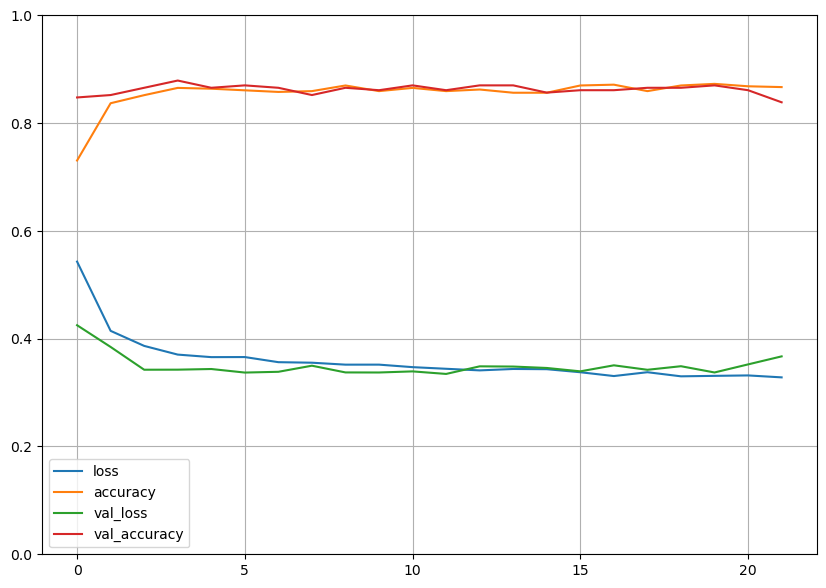

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89       139
         1.0       0.80      0.85      0.82        84

    accuracy                           0.86       223
   macro avg       0.85      0.86      0.85       223
weighted avg       0.86      0.86      0.86       223



In [66]:
import tensorflow as tf
from tensorflow import keras

checkpoint_cb = keras.callbacks.ModelCheckpoint('keras_model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = keras.Sequential([
                          keras.layers.Flatten(),
                          keras.layers.Dense(32, activation="relu"),
                          keras.layers.Dense(16, activation="relu"),
                          keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs =30, batch_size=1, callbacks=[checkpoint_cb, early_stopping_cb] ,validation_data = (X_test, y_test))

pd.DataFrame(history.history).plot(figsize = (10,7))
plt.grid(True)
plt.ylim(0,1)
plt.show()


model = keras.models.load_model('keras_model.h5')

y_pred = np.round(model.predict(X_test))

print(classification_report(y_pred, y_test))




**Conclusion** : Random Forest is the best model


# Submission

In [67]:
#  RandomForestClassifier
rf_model = model_dic['RandomForestClassifier']
rf_submission = pd.concat([pd.Series(df_test.index+1, name='PassengerId'), pd.Series(rf_model.predict(df_test.drop('Survived', axis=1)), name='Survived').astype(int)], axis=1)
rf_submission.to_csv('submission.csv', index=False)

In [68]:
# XGBClassifier
xgb_model = model_dic['XGBClassifier']
xgb_submission = pd.concat([pd.Series(df_test.index+1, name='PassengerId'), pd.Series(xgb_model.predict(df_test.drop('Survived', axis=1)), name='Survived').astype(int)], axis=1)
# xgb_submission.to_csv('submission.csv', index=False)

In [69]:
# Deep Learning
probabilities = model.predict(df_test.drop('Survived', axis=1))
nn_submission =pd.concat([pd.Series(df_test.index+1, name='PassengerId'), pd.Series([float(round(x[0])) for x in probabilities], name='Survived').astype(int)], axis=1)
# nn_submission.to_csv('submission.csv', index=False)

14/14 [==============================] - 0s 1ms/step


In [70]:
# Concat
cct_submission = np.round(pd.concat([nn_submission['Survived'],xgb_submission['Survived'],rf_submission['Survived']], axis =1).apply(sum, axis=1)/ 3).astype(int)
cct_submission = pd.concat([nn_submission['PassengerId'], cct_submission], axis=1).rename(columns ={0: 'Survived'})
# cct_submission.to_csv('submission.csv', index=False)